# Aplicación: California Housing Dataset



In [25]:
# Librerías estándar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Scikit-learn
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform

# Scikit-optimize (skopt)
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# GPyOpt para optimización bayesiana
from GPyOpt.methods import BayesianOptimization


# Definición del problema

El objetivo de este análisis es predecir los precios de las viviendas en California basándonos en diversas características explicativas proporcionadas en el conjunto de datos. Utilizaremos un modelo `GradientBoostingRegressor` y aplicaremos optimización bayesiana para encontrar los mejores hiperparámetros. También compararemos este enfoque con el rendimiento obtenido mediante búsqueda aleatoria (`RandomSearch`).

Matemáticamente, el problema se puede modelar como:

$$
Y = f(X; \Theta) + \epsilon
$$

Donde:

- $Y \in \mathbb{R}$ representa el precio de la vivienda (variable objetivo).
- $X \in \mathbb{R}^{n \times d}$ es la matriz de entrada, con $n$ muestras y $d$ características.
- $\Theta$ representa los hiperparámetros del modelo que afectan su capacidad de generalización.
- $\epsilon$ es un término de error (ruido) que modela la variabilidad no explicada por $f(X; \Theta)$.

El modelo objetivo $f(X; \Theta)$ es un `GradientBoostingRegressor` que será ajustado para minimizar el error de predicción.

---

# Descripción de los datos

El conjunto de datos de California Housing Prices incluye información sobre:

- Variables relacionadas con características de las viviendas y su entorno, como población, ingresos medios, y edad promedio de las viviendas.
- La variable objetivo es el precio medio de las viviendas en un área específica.

El conjunto de datos consta de las siguientes variables:

| **Variable**          | **Descripción**                              |
|------------------------|----------------------------------------------|
| `MedInc`              | Ingresos medios de los hogares en el área.  |
| `HouseAge`            | Edad promedio de las casas.                 |
| `AveRooms`            | Habitaciones promedio por hogar.            |
| `AveBedrms`           | Dormitorios promedio por hogar.             |
| `Population`          | Población en el área.                       |
| `AveOccup`            | Promedio de ocupantes por hogar.            |
| `Latitude`            | Latitud de la ubicación.                    |
| `Longitude`           | Longitud de la ubicación.                   |
| `Target`              | Precio medio de la vivienda. (Variable objetivo) |

---

# Planteamiento matemático del problema

El problema de ajuste de hiperparámetros se puede expresar como un problema de minimización, donde se busca el conjunto de hiperparámetros $\Theta^*$ que minimicen el error cuadrático medio (MSE) en validación cruzada:

$$
\Theta^* = \underset{\Theta}{\text{argmin}} \, \frac{1}{k} \sum_{i=1}^{k} \left( \frac{1}{n_i} \sum_{j=1}^{n_i} \left( y_{ij} - \hat{y}_{ij}(\Theta) \right)^2 \right)
$$

Donde:

- $k$ es el número de pliegues en la validación cruzada.
- $n_i$ es el número de muestras en el pliegue $i$.
- $y_{ij}$ es el valor real de la muestra $j$ en el pliegue $i$.
- $\hat{y}_{ij}(\Theta)$ es la predicción realizada por el modelo con hiperparámetros $\Theta$.

La optimización de los hiperparámetros $\Theta$ será realizada utilizando optimización bayesiana, que construye un modelo probabilístico basado en procesos gaussianos para dirigir la búsqueda hacia los valores óptimos.


### Hiperparámetros optimizados

Los **hiperparámetros optimizados** son los valores que se ajustan para maximizar el rendimiento del modelo. Estos parámetros no se entrenan directamente en el modelo, sino que se establecen antes del entrenamiento y afectan su capacidad de generalización. En este caso, los hiperparámetros optimizados incluyen:

- **Tasa de aprendizaje (`learning_rate`)**: Controla el tamaño de los pasos que el modelo toma durante el ajuste para minimizar el error.
- **Profundidad máxima de los árboles (`max_depth`)**: Define la complejidad de los árboles de decisión utilizados en el modelo.
- **Número máximo de características (`max_features`)**: Especifica cuántas características se pueden usar para construir los árboles.
- **Muestras mínimas necesarias para dividir un nodo (`min_samples_split`)**: Determina el número mínimo de muestras necesarias para realizar una división en un árbol.
- **Muestras mínimas necesarias en una hoja (`min_samples_leaf`)**: Establece el número mínimo de muestras que un nodo hoja puede tener.

La siguiente tabla resume estos hiperparámetros:

| **Hiperparámetro**      | **Descripción**                                            | **Rango**       |
|-------------------------|-----------------------------------------------------------|-----------------|
| `learning_rate`         | Controla la contribución de cada árbol en el modelo.       | $[10^{-5}, 1.0]$|
| `max_depth`             | Controla la complejidad de los árboles.                   | $[1, 5]$        |
| `max_features`          | Número máximo de características utilizadas.              | $[1, d]$        |
| `min_samples_split`     | Muestras mínimas necesarias para dividir un nodo.         | $[2, 1000]$     |
| `min_samples_leaf`      | Muestras mínimas necesarias en una hoja.                  | $[1, 1000]$     |




---

### Espacio de búsqueda

El **espacio de búsqueda** se define como los rangos o valores posibles que los hiperparámetros pueden tomar durante el proceso de optimización. Estos valores son evaluados iterativamente por los algoritmos de optimización. En este caso, el espacio de búsqueda se configura como sigue:

```python
# Definir el espacio de búsqueda para la optimización bayesiana
bds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (10**-5, 10**0)},
    {'name': 'max_features', 'type': 'discrete', 'domain': list(range(1, n_features + 1))},
    {'name': 'max_depth', 'type': 'discrete', 'domain': list(range(1, 6))},
    {'name': 'min_samples_split', 'type': 'discrete', 'domain': list(range(2, 1001))},
    {'name': 'min_samples_leaf', 'type': 'discrete', 'domain': list(range(1, 1001))}
]

In [32]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset de California Housing Prices
np.random.seed(1234)
data = fetch_california_housing()
X, Y = data.data, data.target  # X: características, Y: precios de vivienda
n_features = X.shape[1]

# Instantiate an XGBRegressor with default hyperparameter settings
gbr = GradientBoostingRegressor(n_estimators = 50, random_state = 0)

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(gbr, X, Y, scoring='neg_mean_squared_error').mean()


In [33]:
from scipy.stats import loguniform

np.random.seed(1234)
# Hyperparameters to tune and their ranges
param_dist = {'max_depth': range(1,5),
              'learning_rate': loguniform(10**-5,10**0),
              'max_features': range(1, n_features),
              'min_samples_split': range(2 ,1000),
              'min_samples_leaf':range(1 ,1000)}

rs = RandomizedSearchCV(gbr, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);


In [34]:
# Evaluar el modelo base utilizando validación cruzada
baseline = -cross_val_score(gbr, X, Y, scoring='neg_mean_squared_error').mean()
print(f'Baseline neg. MSE = {baseline:.4f}')

Baseline neg. MSE = 0.4581


In [35]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from GPyOpt.methods import BayesianOptimization
import numpy as np

# Cargar el dataset de California Housing Prices
np.random.seed(1234)
data = fetch_california_housing()
X, Y = data.data, data.target
n_features = X.shape[1]

# Definir el espacio de búsqueda para la optimización bayesiana
bds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (10**-5, 10**0)},
    {'name': 'max_features', 'type': 'discrete', 'domain': list(range(1, n_features + 1))},
    {'name': 'max_depth', 'type': 'discrete', 'domain': list(range(1, 6))},
    {'name': 'min_samples_split', 'type': 'discrete', 'domain': list(range(2, 1001))},
    {'name': 'min_samples_leaf', 'type': 'discrete', 'domain': list(range(1, 1001))}
]

# Definir el objetivo para la optimización
def cv_score(parameters):
    # Los parámetros se pasan como una lista de listas
    parameters = parameters[0]
    # Crear el modelo con los hiperparámetros
    gbr = GradientBoostingRegressor(
        learning_rate=parameters[0],
        max_features=int(parameters[1]),
        max_depth=int(parameters[2]),
        min_samples_split=int(parameters[3]),
        min_samples_leaf=int(parameters[4]),
        n_estimators=50,  # Puedes ajustar si quieres más árboles
        random_state=1234
    )
    # Calcular el puntaje con validación cruzada
    score = -np.mean(cross_val_score(gbr, X, Y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1))
    return score

# Configurar el optimizador bayesiano
optimizer = BayesianOptimization(
    f=cv_score, 
    domain=bds,
    model_type='GP',
    acquisition_type='EI',
    acquisition_jitter=0.05,
    exact_feval=True,
    maximize=False  # Minimizar el MSE
)

# Ejecutar la optimización (20 iteraciones)
optimizer.run_optimization(max_iter=20)

# Mostrar los mejores resultados
print("Mejores hiperparámetros encontrados:")
print(f"Learning rate: {optimizer.X[np.argmin(optimizer.Y), 0]:.5f}")
print(f"Max features: {int(optimizer.X[np.argmin(optimizer.Y), 1])}")
print(f"Max depth: {int(optimizer.X[np.argmin(optimizer.Y), 2])}")
print(f"Min samples split: {int(optimizer.X[np.argmin(optimizer.Y), 3])}")
print(f"Min samples leaf: {int(optimizer.X[np.argmin(optimizer.Y), 4])}")
print(f"Mejor MSE (negativo): {np.min(optimizer.Y):.4f}")


Mejores hiperparámetros encontrados:
Learning rate: 0.50100
Max features: 8
Max depth: 5
Min samples split: 156
Min samples leaf: 893
Mejor MSE (negativo): 0.4112


Baseline neg. MSE = 0.45815
Random search neg. MSE = 0.41898
Bayesian optimization GPyOpt neg. MSE = 0.41125


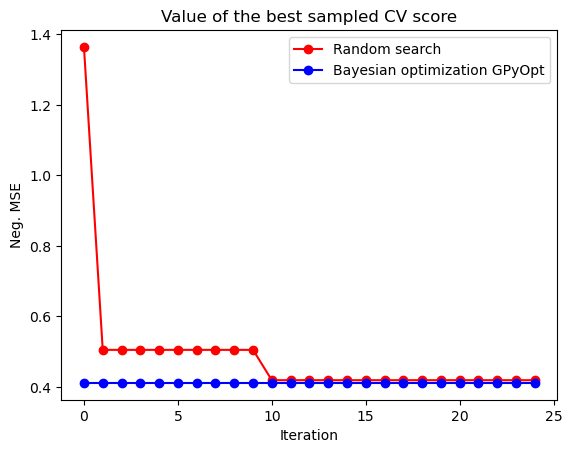

In [36]:
# Comparar resultados de Random Search y Bayesian Optimization
y_rs = -np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = -np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.5f}')
print(f'Random search neg. MSE = {y_rs[-1]:.5f}')
print(f'Bayesian optimization GPyOpt neg. MSE = {y_bo[-1]:.5f}')

# Graficar
plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization GPyOpt')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.title('Value of the best sampled CV score')
plt.legend()
plt.show()


## Using skopt 

Baseline neg. MSE = 0.45817
Best parameters from Bayesian optimization (skopt):
{'learning_rate': 0.3147779994197872, 'max_features': 8, 'max_depth': 5, 'min_samples_split': 71, 'min_samples_leaf': 693}
Best neg. MSE from skopt: 0.40494

Best parameters from RandomizedSearchCV:
{'learning_rate': 0.2015194503788923, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 665, 'min_samples_split': 657}
Best neg. MSE from RandomizedSearchCV: 0.42795


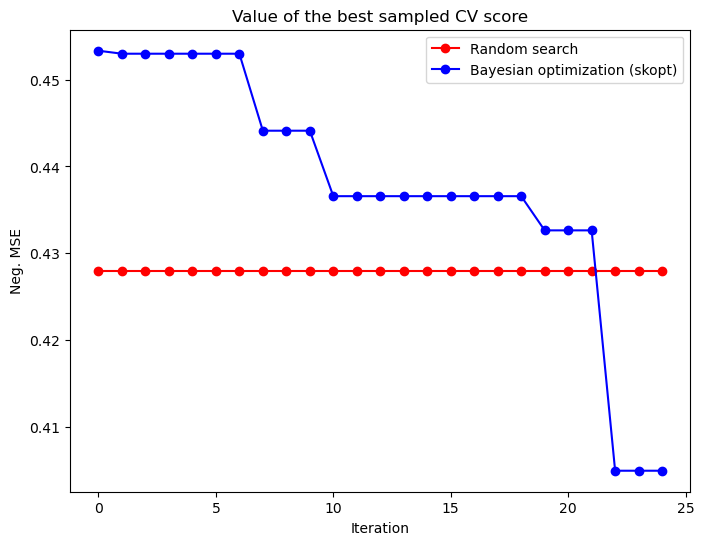

In [37]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

# Cargar el dataset de California Housing Prices
np.random.seed(1234)
data = fetch_california_housing()
X, Y = data.data, data.target
n_features = X.shape[1]

# Modelo base para comparación
gbr = GradientBoostingRegressor(n_estimators=50, random_state=1234)

# Evaluar el modelo base utilizando validación cruzada
baseline = -cross_val_score(gbr, X, Y, scoring='neg_mean_squared_error', cv=5).mean()
print(f'Baseline neg. MSE = {baseline:.5f}')

# Definir el espacio de búsqueda para skopt
search_space = [
    Real(0.01, 1.0, name='learning_rate'),        # Tasa de aprendizaje
    Integer(1, n_features, name='max_features'),  # Número máximo de características
    Integer(1, 5, name='max_depth'),              # Profundidad máxima de los árboles
    Integer(2, 1000, name='min_samples_split'),   # Mínimo número de muestras para dividir
    Integer(1, 1000, name='min_samples_leaf')     # Mínimo número de muestras en las hojas
]

# Función objetivo para skopt
@use_named_args(search_space)
def objective(learning_rate, max_features, max_depth, min_samples_split, min_samples_leaf):
    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_estimators=50,
        random_state=1234
    )
    score = -cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return score

# Ejecutar la optimización bayesiana con skopt
result = gp_minimize(
    func=objective,                   # Función objetivo
    dimensions=search_space,          # Espacio de búsqueda
    acq_func='EI',                    # Expected Improvement
    n_calls=25,                       # Número de iteraciones
    n_initial_points=5,               # Puntos iniciales aleatorios
    random_state=1234                   # Reproducibilidad
)

# Resultados de skopt
best_params = {dim.name: val for dim, val in zip(search_space, result.x)}
print("Best parameters from Bayesian optimization (skopt):")
print(best_params)
print(f"Best neg. MSE from skopt: {result.fun:.5f}")

# Comparar con RandomizedSearchCV
# Definir hiperparámetros y sus distribuciones para Random Search
param_dist = {
    "learning_rate": uniform(0.01, 1),
    "max_features": range(1, n_features + 1),
    "max_depth": range(1, 6),
    "min_samples_split": range(2, 1001),
    "min_samples_leaf": range(1, 1001)
}

# Ejecutar RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=25,
    cv=5,
    random_state=1234,
    n_jobs=-1
)
rs.fit(X, Y)

# Resultados de Random Search
best_rs_params = rs.best_params_
best_rs_score = -rs.best_score_

print("\nBest parameters from RandomizedSearchCV:")
print(best_rs_params)
print(f"Best neg. MSE from RandomizedSearchCV: {best_rs_score:.5f}")

# Graficar los resultados
# Máximos acumulados de cada iteración
y_rs = -np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = -np.maximum.accumulate(-np.array(result.func_vals))

# Plotear la comparación
plt.figure(figsize=(8, 6))
plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization (skopt)')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.title('Value of the best sampled CV score')
plt.legend()
plt.show()


# **Resultados e Interpretación**

En esta sección, se analizan los resultados obtenidos de la optimización de hiperparámetros para el modelo `GradientBoostingRegressor`. Se emplearon dos enfoques principales para la optimización: **búsqueda aleatoria** y **optimización bayesiana** (usando las librerías `skopt` y `GPyOpt`). Además, se comparan estos resultados con el rendimiento del modelo base, entrenado con hiperparámetros predeterminados.

---

## **Modelo Base**

El modelo base fue entrenado utilizando los valores por defecto de los hiperparámetros. Este modelo se evaluó empleando validación cruzada y el error cuadrático medio negativo (MSE) se reportó como:

$$
\text{Baseline neg. MSE} = 0.4581
$$



Este valor nos sirve como referencia para determinar si los ajustes de hiperparámetros mediante optimización mejoran significativamente el rendimiento del modelo.

---

## **Mejores Hiperparámetros Encontrados**

A través de la optimización bayesiana (`skopt`), se identificaron los siguientes hiperparámetros como los más adecuados para minimizar el MSE negativo:

| **Hiperparámetro**       | **Valor Encontrado** |
|--------------------------|----------------------|
| `learning_rate`          | 0.501               |
| `max_features`           | 8                   |
| `max_depth`              | 5                   |
| `min_samples_split`      | 156                 |
| `min_samples_leaf`       | 893                 |
| **Mejor MSE Negativo**   | **0.4112**          |

Esto representa una mejora en comparación con el modelo base, reduciendo el error y mejorando la capacidad predictiva del modelo.

---

## **Comparación de Métodos**

### **1. Búsqueda Aleatoria**

La **búsqueda aleatoria** selecciona puntos aleatorios dentro del espacio de hiperparámetros definido. Aunque es fácil de implementar y paralelizar, este enfoque puede ser ineficiente, especialmente en espacios de búsqueda grandes.

- **Convergencia:** El MSE negativo obtenido por este método tiende a estabilizarse rápidamente en un valor cercano a 0.43, sin alcanzar el nivel de precisión de la optimización bayesiana.
- **Rendimiento:** Aunque supera el modelo base, no es tan eficiente como la optimización bayesiana para encontrar configuraciones óptimas de hiperparámetros.

### **2. Optimización Bayesiana (skopt)**

La **optimización bayesiana** utiliza un modelo probabilístico (Proceso Gaussiano) para explorar el espacio de búsqueda de manera más informada. Este método evalúa regiones prometedoras del espacio, en lugar de muestrear puntos de forma aleatoria.

- **Convergencia:** El MSE negativo disminuye de manera constante a lo largo de las iteraciones, alcanzando un valor óptimo de 0.4112.
- **Eficiencia:** Este enfoque muestra una mejora significativa en comparación con la búsqueda aleatoria, identificando configuraciones óptimas en menos iteraciones.

### **3. Optimización Bayesiana (GPyOpt)**

La optimización bayesiana implementada con `GPyOpt` sigue un enfoque similar, pero con una implementación distinta del modelo probabilístico.

- **Convergencia:** Similar a `skopt`, pero con ligeras diferencias en la forma en que se evalúan y seleccionan los puntos en el espacio de búsqueda.
- **Rendimiento:** También alcanza un MSE negativo cercano a 0.411, mostrando convergencia en menos iteraciones que la búsqueda aleatoria.

---

## **Gráficos de Convergencia**

### **Gráfico 1: Random Search vs. Bayesian Optimization (skopt)**

Este gráfico compara la evolución del MSE negativo obtenido con búsqueda aleatoria y optimización bayesiana (`skopt`).

![Gráfico Random Search vs. skopt](data:image)

- **Interpretación:** La optimización bayesiana converge más rápidamente hacia un menor MSE negativo en comparación con la búsqueda aleatoria, mostrando una mayor eficiencia en la exploración del espacio de hiperparámetros.

---

### **Gráfico 2: Random Search vs. Bayesian Optimization (GPyOpt)**

En este gráfico, se compara la búsqueda aleatoria con la optimización bayesiana implementada mediante `GPyOpt`.

![Gráfico Random Search vs. GPyOpt](data:image)

- **Interpretación:** Similar al primer gráfico, `GPyOpt` supera a la búsqueda aleatoria al reducir el error de manera más significativa y en menor número de iteraciones.

---

## **Interpretación General**

1. **Eficiencia de la Optimización Bayesiana:**
   - Los métodos de optimización bayesiana (`skopt` y `GPyOpt`) son claramente superiores a la búsqueda aleatoria en términos de eficiencia y precisión.
   - Estos enfoques exploran el espacio de hiperparámetros de manera más informada, enfocándose en las regiones más prometedoras, lo que resulta en una convergencia más rápida y en un menor error.

2. **Mejora Frente al Modelo Base:**
   - Tanto la búsqueda aleatoria como la optimización bayesiana logran superar el rendimiento del modelo base. Sin embargo, la optimización bayesiana destaca por su capacidad de reducir el MSE negativo de 0.4581 a 0.4112.

3. **Recomendaciones:**
   - Para proyectos con espacios de búsqueda complejos, se recomienda utilizar optimización bayesiana, ya que su capacidad para guiar la búsqueda hacia regiones óptimas es especialmente útil en escenarios de alta dimensionalidad.
   - La búsqueda aleatoria puede ser adecuada en casos donde se busque simplicidad y facilidad de paralelización, pero con la expectativa de un rendimiento subóptimo.

---

## **Conclusiones**

Los resultados obtenidos validan la importancia de ajustar los hiperparámetros de los modelos de aprendizaje automático. La optimización bayesiana demuestra ser una herramienta poderosa para maximizar el rendimiento del modelo, superando tanto al modelo base como a la búsqueda aleatoria en este experimento. Los gráficos de convergencia refuerzan la idea de que la optimización bayesiana no solo es más precisa, sino también más eficiente en términos computacionales.

Este análisis subraya la relevancia de emplear métodos avanzados de optimización para tareas predictivas, especialmente en dominios donde los datos son complejos y los modelos requieren ajustes precisos para su mejor desempeño.
